In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

data = pd.read_csv('assets/datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [2]:
data[data.Store==1].sort_index

<bound method DataFrame.sort_index of             Store  Dept  Weekly_Sales IsHoliday
Date                                           
2010-02-05      1     1      24924.50     False
2010-02-12      1     1      46039.49      True
2010-02-19      1     1      41595.55     False
2010-02-26      1     1      19403.54     False
2010-03-05      1     1      21827.90     False
2010-03-12      1     1      21043.39     False
2010-03-19      1     1      22136.64     False
2010-03-26      1     1      26229.21     False
2010-04-02      1     1      57258.43     False
2010-04-09      1     1      42960.91     False
2010-04-16      1     1      17596.96     False
2010-04-23      1     1      16145.35     False
2010-04-30      1     1      16555.11     False
2010-05-07      1     1      17413.94     False
2010-05-14      1     1      18926.74     False
2010-05-21      1     1      14773.04     False
2010-05-28      1     1      15580.43     False
2010-06-04      1     1      17558.09     False
20

#### Deliverable

Look back at the readme from wednesday's lecture on timeseries for good information about these models and acf/pacf plots!

- Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [5]:
data.index = pd.to_datetime(data.index)
store1 = data[data.Store==1]
store1 = pd.DataFrame(store1['Weekly_Sales'].resample('1D').sum(),columns=['Weekly_Sales'])
store1.dropna(inplace=True)

In [6]:
store1.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


- Plot the rolling_mean for Weekly_Sales. What general trends do you observe?

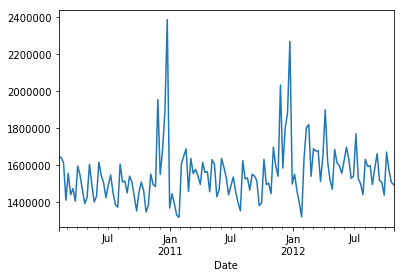

In [7]:
store1['Weekly_Sales'].rolling(window=1).mean().plot()

It's pretty unsurprising to see that sales jump right before January--Christmas.

- Compute the 1, 2, 52 autocorrelations for Weekly_Sales and create an autocorrelation and partial autocorrelation plot.

In [8]:
store1.Weekly_Sales.autocorr(lag=1) #previous week = 0.30215827941131262
store1.Weekly_Sales.autocorr(lag=2) #2 weeks prior = 0.12741313055390105
store1.Weekly_Sales.autocorr(lag=52) #previous year = 0.89537602947770101

0.89537602947770079

We can see from the autocorrelation values that the weekly_sales are highly correlated with the sales from the year leading up to that week

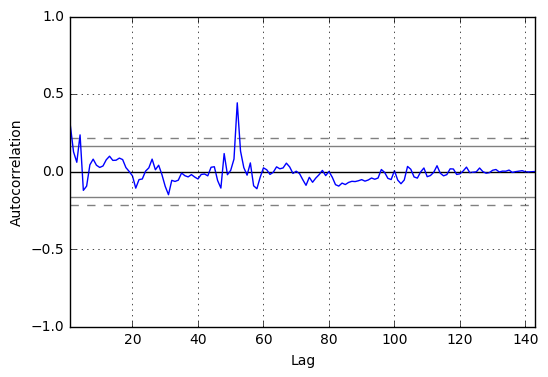

In [92]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(store1['Weekly_Sales'])

This chart also shows that around week 52, the autocorrelation is highest.

- BONUS: What do the acf() and pacf() plots say about the type of model you want to build?

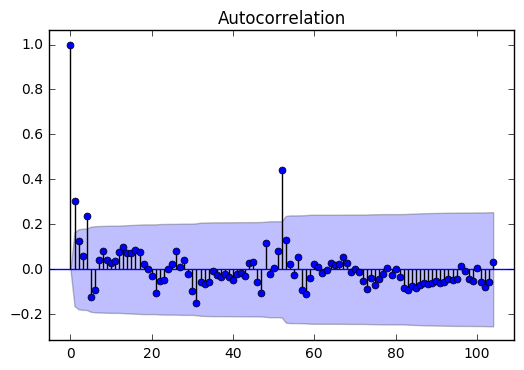

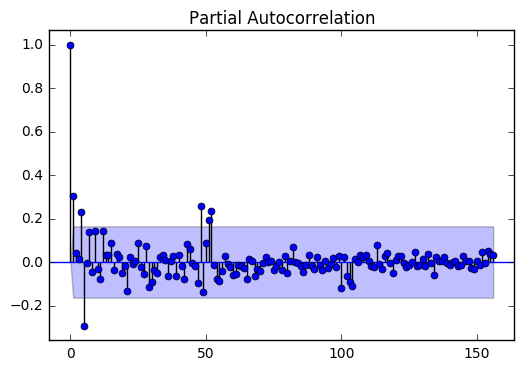

In [103]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt

plot_acf(store1.Weekly_Sales, lags=52*2)
plt.show()

plot_pacf(store1.Weekly_Sales, lags=52*3)
plt.show()

# These plots tell us how many p's and q's we need

- "Difference" the data by converting the sales into change in sales (diff function is convenient for doing this.)
- Split the weekly sales data in a training and test set - using 75% of the data for training.

In [47]:
store1_diff = store1.diff(periods=1)
store1_diff.fillna(0,inplace=True)

X_train = store1_diff[0:107]
X_test = store1_diff.index[107:]

In [60]:
import datetime as dt
X_test = pd.to_datetime(X_test)

X_test

DatetimeIndex(['2012-02-24', '2012-03-02', '2012-03-09', '2012-03-16',
               '2012-03-23', '2012-03-30', '2012-04-06', '2012-04-13',
               '2012-04-20', '2012-04-27', '2012-05-04', '2012-05-11',
               '2012-05-18', '2012-05-25', '2012-06-01', '2012-06-08',
               '2012-06-15', '2012-06-22', '2012-06-29', '2012-07-06',
               '2012-07-13', '2012-07-20', '2012-07-27', '2012-08-03',
               '2012-08-10', '2012-08-17', '2012-08-24', '2012-08-31',
               '2012-09-07', '2012-09-14', '2012-09-21', '2012-09-28',
               '2012-10-05', '2012-10-12', '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', freq=None)

- Create an AR(1) model on the training data and compute the mean absolute error of the predictions. How effective is this model?


In [17]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(store1_diff, (1, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:                     ARMA(1, 0)   Log Likelihood               -1925.240
Method:                       css-mle   S.D. of innovations         170033.900
Date:                Thu, 04 May 2017   AIC                           3856.480
Time:                        09:20:47   BIC                           3865.368
Sample:                    02-05-2010   HQIC                          3860.092
                         - 10-26-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1049.1690   1.04e+04     -0.101      0.920   -2.14e+04    1.93e+04
ar.L1.Weekly_Sales    -0.3731      0.077     -4.836      0.000      -0.524      -0.222
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.6803           +0.0000j            2.6803            0.5000
-----------------------------------------------------------------------------
"""

In [63]:
from sklearn.metrics import mean_absolute_error
# X_test = np.ravel(X_test)
# y_pred = model.predict(X_test)
# y_pred = np.ravel(y_pred)
# mean_absolute_error(y_test, y_pred)


ar_coef = model.arparams
yhat = model.predict(ar_coef, X_test)
predictions.append(yhat)


ValueError: Unknown string format

- Plot the residuals - where are their significant errors?


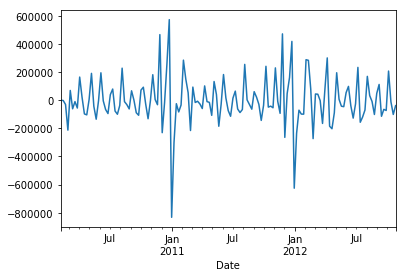

In [19]:
model.resid.plot()

- Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set?

- Assemble your findings, including any useful graphs.